# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from lifelines import KaplanMeierFitter

## Survival analysis

If we have an unbiased sample of complete lifetimes, we can compute the survival function from the CDF and the hazard function from the survival function.

Here's the distribution of pregnancy length in the NSFG dataset.

In [3]:
import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1, 3, 4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')

The survival function is just the complementary CDF.

In [4]:
import survival

def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [5]:
sf = MakeSurvivalFromCdf(cdf, label='survival')

In [6]:
print(cdf[13])
print(sf[13])

0.1397801412101171
0.8602198587898829


Here's the CDF and SF.

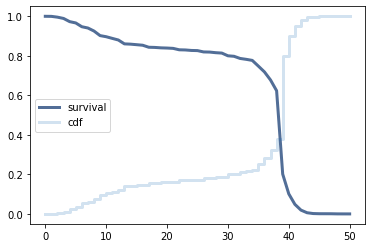

In [7]:
thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left')

In [8]:
# Mine
def DiscreteRv(a):
    """Creates a scipy.stats discrete_rv.

    Arguments:
        a {array-like} -- a single data set, will be flattened if it is not already 1-D

    Returns:
        An instance of scipy.stats discrete_rv representing the input data
    """
    val,cnt = np.unique(a, return_counts=True)
    
    return stats.rv_discrete(values=(val,cnt/sum(cnt)))

In [9]:
sf_rv = DiscreteRv(complete)

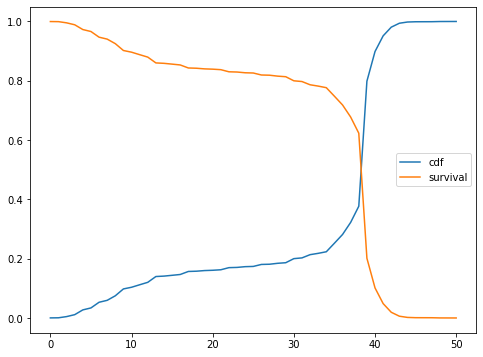

In [10]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(sf_rv.xk, sf_rv.cdf(sf_rv.xk), label='cdf')
ax.plot(sf_rv.xk, sf_rv.sf(sf_rv.xk), label='survival')

plt.legend()

And here's the hazard function.

In [11]:
hf = sf.MakeHazardFunction(label='hazard')
print(hf[39])

0.6767068273092369


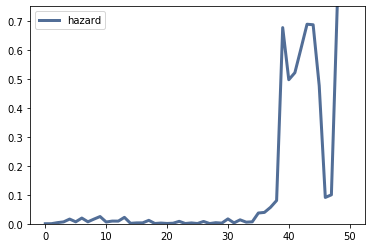

In [12]:
thinkplot.Plot(hf)
thinkplot.Config(ylim=[0, 0.75], loc='upper left')

In [13]:
# My own function that computes the hazard function from my rv
def HazardValues(rv):
    hazards=[]
    
    for k in rv.xk[:-1]:
        hazard = (rv.sf(k) - rv.sf(k+1)) / rv.sf(k)
        hazards.append(hazard)
    
    return rv.xk[:-1], np.array(hazards)

In [14]:
xs,ys = HazardValues(sf_rv)

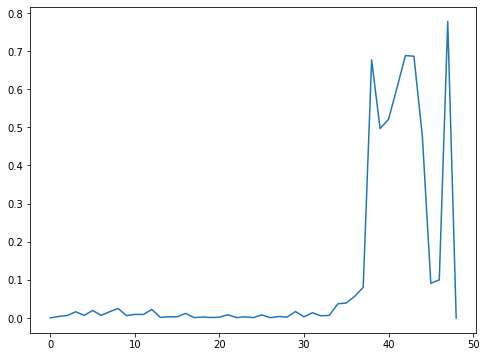

In [15]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(xs, ys)

## Age at first marriage

We'll use the NSFG respondent file to estimate the hazard function and survival function for age at first marriage.

In [16]:
resp6 = nsfg.ReadFemResp()

We have to clean up a few variables.

In [17]:
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6['agemarry'] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6['age'] = (resp6.cmintvw - resp6.cmbirth) / 12.0

And the extract the age at first marriage for people who are married, and the age at time of interview for people who are not.

In [18]:
complete = resp6[resp6.evrmarry==1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry==0].age

The following function uses Kaplan-Meier to estimate the hazard function.

In [19]:
from collections import defaultdict, Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

Here is the hazard function and corresponding survival function. 

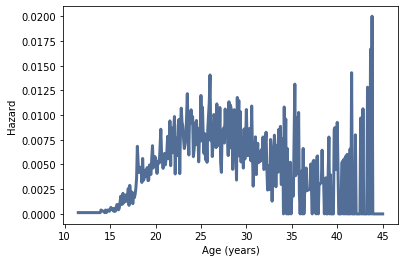

In [20]:
hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')

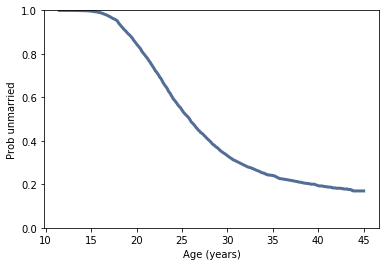

In [21]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 ylim=[0, 1])

In [22]:
# Mine, try using lifeline Kaplan-Meier
# First though need to set up the data properly
# For my use I will need a duration which is age at marriage if married or age if not
df_p1 = pd.DataFrame({'duration' : complete, 'event' : np.ones(len(complete), dtype='int')})
df_p2 = pd.DataFrame({'duration' : ongoing, 'event' : np.zeros(len(ongoing), dtype='int')})
df_km = pd.concat([df_p1, df_p2])

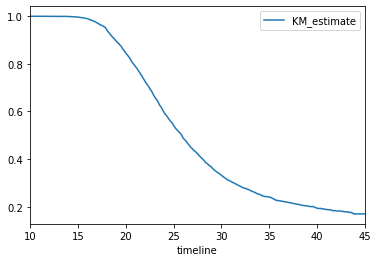

In [23]:
T = df_km["duration"]
E = df_km["event"]

kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, entry=np.full(shape=len(df_km), fill_value=10))
kmf.survival_function_.plot()

In [24]:
np.full(shape=len(df_km), fill_value=10)

array([10, 10, 10, ..., 10, 10, 10])

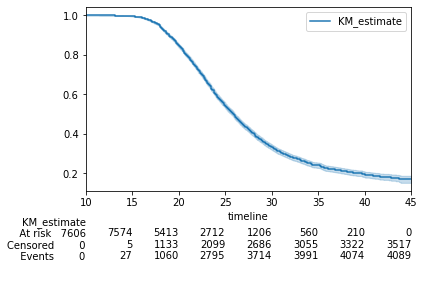

In [25]:
kmf.plot(at_risk_counts=True)
plt.tight_layout()

In [26]:
kmf.predict(30)

0.3315018933321605

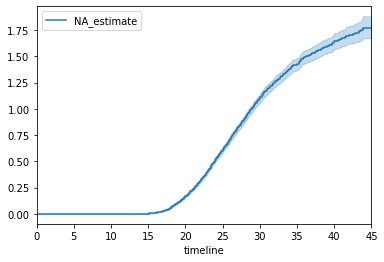

In [27]:
# Try the hazard function fitter too
# Not sure what the y-values represent, it's a "cumulative hazard function" estimate
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
naf.plot()

In [28]:
# Make my own estimate hazard function function
def EstimateHazardFunctionValues(duration, event_observed, verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    duration: list of time durations until event (or up until time of measure if ongoing)
    event_observed: list indicating whether event was observed or not (1,0)
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(duration)):
        raise ValueError("duration contains NaNs")
    if np.sum(np.isnan(event_observed)):
        raise ValueError("event_observed contains NaNs")

    # Create a DataFrame to hold both the duration and event data
    df = pd.DataFrame({'duration' : duration, 'event' : event_observed})
        
    hist_complete = Counter(df[df.event == 1].duration)
    hist_ongoing = Counter(df[df.event == 0].duration)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(df)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return lams

In [29]:
my_hf = EstimateHazardFunctionValues(df_km.duration, df_km.event)

In [30]:
my_hf

11.500000    0.000131
11.750000    0.000131
12.500000    0.000132
13.166667    0.000132
13.500000    0.000132
13.916667    0.000132
14.000000    0.000395
14.250000    0.000263
14.416667    0.000132
14.500000    0.000395
14.583333    0.000132
14.750000    0.000395
14.833333    0.000395
14.916667    0.000264
15.000000    0.000396
15.083333    0.000660
15.166667    0.000529
15.250000    0.000398
15.333333    0.000532
15.416667    0.000267
15.500000    0.000535
15.583333    0.000268
15.666667    0.000672
15.750000    0.000945
15.833333    0.000949
15.916667    0.000408
16.000000    0.000546
16.083333    0.001096
16.166667    0.001785
16.250000    0.000965
               ...   
42.333333    0.000000
42.416667    0.000000
42.500000    0.000000
42.583333    0.009709
42.666667    0.000000
42.750000    0.000000
42.833333    0.010638
42.916667    0.000000
43.083333    0.000000
43.166667    0.000000
43.250000    0.000000
43.333333    0.012821
43.416667    0.000000
43.500000    0.000000
43.583333 

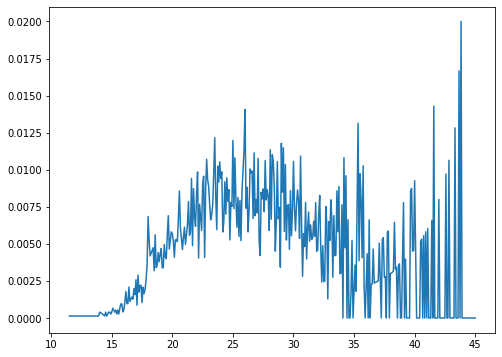

In [31]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(my_hf.index, my_hf.values)

## Quantifying uncertainty

To see how much the results depend on random sampling, we'll use a resampling process again.

In [32]:
def EstimateMarriageSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [33]:
def ResampleSurvival(resp, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """ 
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

In [34]:
low, high = resp6.agemarry.min(), resp6.agemarry.max()
ts = np.arange(low, high, 1/12.0)

In [35]:
ss_seq = []
for _ in range(101):
    sample = thinkstats2.ResampleRowsWeighted(resp6)
    _, sf = EstimateMarriageSurvival(sample)
    ss_seq.append(sf.Probs(ts))

In [36]:
low1, high1 = thinkstats2.PercentileRows(ss_seq, [5, 95])

In [37]:
high1

array([1.        , 1.        , 1.        , 0.99986858, 0.99984671,
       0.99983962, 0.99982504, 0.99981047, 0.99979589, 0.99978131,
       0.99976673, 0.99975215, 0.99973757, 0.99970476, 0.99967196,
       0.99966259, 0.99965634, 0.99965009, 0.99964384, 0.99963759,
       0.99963134, 0.9996251 , 0.99961885, 0.9996126 , 0.99960625,
       0.99957945, 0.99955316, 0.99952688, 0.99950059, 0.9994752 ,
       0.99934366, 0.9992999 , 0.99925615, 0.99921239, 0.99914631,
       0.99908088, 0.99895054, 0.99890682, 0.99886279, 0.99881781,
       0.99855586, 0.9980315 , 0.99737636, 0.99711195, 0.99671415,
       0.99632463, 0.99619135, 0.99605794, 0.99500082, 0.99486171,
       0.99433468, 0.99393318, 0.99313145, 0.99271806, 0.99258294,
       0.99217664, 0.99083985, 0.98973448, 0.98840899, 0.98635823,
       0.98510227, 0.98386226, 0.98288376, 0.98170192, 0.97959684,
       0.97831714, 0.97522415, 0.97428871, 0.97112329, 0.96884054,
       0.96731672, 0.96546875, 0.9646579 , 0.96233735, 0.96088

The following plot shows the survival function based on the raw data and a 90% CI based on resampling.

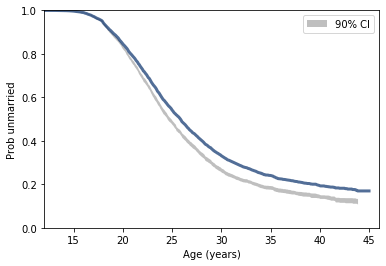

In [38]:
ResampleSurvival(resp6)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[12, 46],
                 ylim=[0, 1],
                 loc='upper right')

The SF based on the raw data falls outside the 90% CI because the CI is based on weighted resampling, and the raw data is not.  You can confirm that by replacing `ResampleRowsWeighted` with `ResampleRows` in `ResampleSurvival`.

## More data

To generate survivial curves for each birth cohort, we need more data, which we can get by combining data from several NSFG cycles.

In [39]:
resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [40]:
resps = [resp5, resp6, resp7]

The following is the code from `survival.py` that generates SFs broken down by decade of birth.

In [41]:
def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

Here are the results for the combined data.

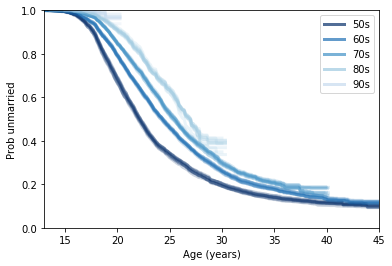

In [42]:
PlotResampledByDecade(resps)
thinkplot.Config(xlabel='Age (years)',
                   ylabel='Prob unmarried',
                   xlim=[13, 45],
                   ylim=[0, 1])

We can generate predictions by assuming that the hazard function of each generation will be the same as for the previous generation.

In [43]:
def PlotPredictionsByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

And here's what that looks like.

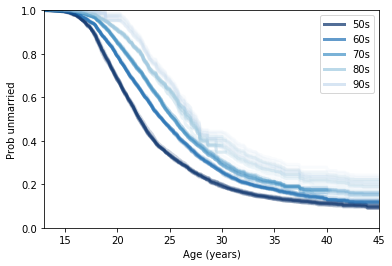

In [44]:
PlotResampledByDecade(resps, predict_flag=True)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[13, 45],
                 ylim=[0, 1])

## Remaining lifetime

Distributions with difference shapes yield different behavior for remaining lifetime as a function of age.

In [45]:
preg = nsfg.ReadFemPreg()

complete = preg.query('outcome in [1, 3, 4]').prglngth
print('Number of complete pregnancies', len(complete))
ongoing = preg[preg.outcome == 6].prglngth
print('Number of ongoing pregnancies', len(ongoing))

hf = EstimateHazardFunction(complete, ongoing)
sf1 = hf.MakeSurvival()

Number of complete pregnancies 11189
Number of ongoing pregnancies 352


Here's the expected remaining duration of a pregnancy as a function of the number of weeks elapsed.  After week 36, the process becomes "memoryless".

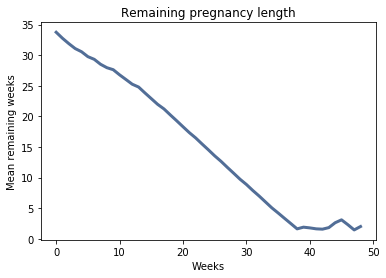

In [46]:
rem_life1 = sf1.RemainingLifetime()
thinkplot.Plot(rem_life1)
thinkplot.Config(title='Remaining pregnancy length',
                 xlabel='Weeks',
                 ylabel='Mean remaining weeks')

And here's the median remaining time until first marriage as a function of age.

In [47]:
hf, sf2 = EstimateMarriageSurvival(resp6)

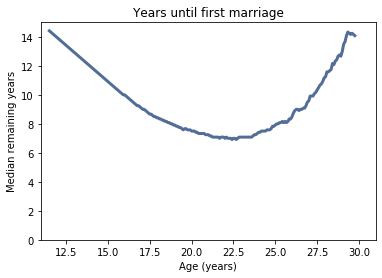

In [48]:
func = lambda pmf: pmf.Percentile(50)
rem_life2 = sf2.RemainingLifetime(filler=np.inf, func=func)
    
thinkplot.Plot(rem_life2)
thinkplot.Config(title='Years until first marriage',
                 ylim=[0, 15],
                 xlim=[11, 31],
                 xlabel='Age (years)',
                 ylabel='Median remaining years')

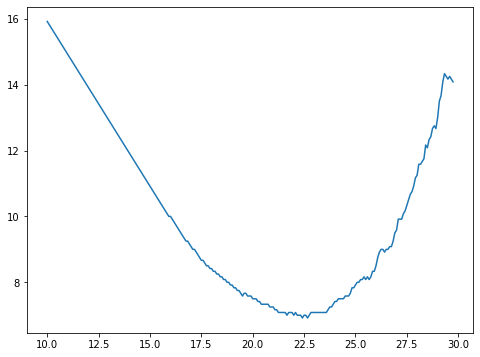

In [52]:
# The kmf object has a remaining lifetime attribute (conditional_time_to_event_)

fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(kmf.conditional_time_to_event_)

In [ ]:
# Read and understand the parts on cohorts and remaining lifetimes

## Exercises

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [28]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [29]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

In [30]:
# Solution goes here

In [31]:
# Solution goes here

In [32]:
# Solution goes here

In [33]:
# Solution goes here

In [34]:
# Solution goes here